In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

# Para visualización de datos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Para cargar los datos
# -----------------------------------------------------------------------
import pickle

# Para sistemas de recomendacion basados en cotenido
# -----------------------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion

# Importamos nuestras funciones
# -----------------------------------------------------------------------
from src import soporte_sistemas_recomendacion as sr

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

In [2]:
# cargamos lso datos
df = pd.read_csv('datos/games_description.csv')
df.head(2)


,name,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,Black Myth: Wukong,Black Myth: Wukong is an action RPG rooted in ...,About This Game\n\t\t\t\t\t\t\tBlack Myth: Wuk...,"['Mythology', 'Action RPG', 'Action', 'RPG', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"19 Aug, 2024",['Game Science'],['Game Science'],Overwhelmingly Positive,"(654,820)","51,931",https://store.steampowered.com/app/2358720/Bla...
1,Counter-Strike 2,"For over two decades, Counter-Strike has offer...",About This Game\n\t\t\t\t\t\t\tFor over two de...,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...","['OS: Windows® 10', 'Processor: 4 hardware CPU...","['OS: Windows® 10', 'Processor: 4 hardware CPU...","21 Aug, 2012",['Valve'],['Valve'],Very Positive,"(8,313,603)","2,258,990",https://store.steampowered.com/app/730/Counter...


In [3]:
# selecion de columnas objetivo para realizar nuestro filtro colaborativo 
df_contenido = df[["name", "short_description", "long_description", "genres", "developer","overall_player_rating","number_of_reviews_from_purchased_people"]]
df_contenido.head()
df_contenido = df.rename(columns={'name': 'title'})
df_contenido.head()


,title,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,Black Myth: Wukong,Black Myth: Wukong is an action RPG rooted in ...,About This Game\n\t\t\t\t\t\t\tBlack Myth: Wuk...,"['Mythology', 'Action RPG', 'Action', 'RPG', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"19 Aug, 2024",['Game Science'],['Game Science'],Overwhelmingly Positive,"(654,820)","51,931",https://store.steampowered.com/app/2358720/Bla...
1,Counter-Strike 2,"For over two decades, Counter-Strike has offer...",About This Game\n\t\t\t\t\t\t\tFor over two de...,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...","['OS: Windows® 10', 'Processor: 4 hardware CPU...","['OS: Windows® 10', 'Processor: 4 hardware CPU...","21 Aug, 2012",['Valve'],['Valve'],Very Positive,"(8,313,603)","2,258,990",https://store.steampowered.com/app/730/Counter...
2,"Warhammer 40,000: Space Marine 2",Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
3,Cyberpunk 2077,"Cyberpunk 2077 is an open-world, action-advent...",About This Game\nCyberpunk 2077 is an open-wor...,"['Cyberpunk', 'Open World', 'Nudity', 'RPG', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"10 Dec, 2020",['CD PROJEKT RED'],['CD PROJEKT RED'],Very Positive,"(680,264)","324,124",https://store.steampowered.com/app/1091500/Cyb...
4,ELDEN RING,THE CRITICALLY ACCLAIMED FANTASY ACTION RPG. R...,About This Game\nTHE CRITICALLY ACCLAIMED FANT...,"['Souls-like', 'Dark Fantasy', 'Open World', '...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"25 Feb, 2022","['FromSoftware, Inc.']","['FromSoftware, Inc.', 'Bandai Namco Entertain...",Very Positive,"(705,261)","491,741",https://store.steampowered.com/app/1245620/ELD...


In [4]:
# Crear la columna 'tags' combinando las demás columnas excepto 'name'
df_contenido['tags_v2'] = df_contenido.drop(columns=['title']).apply(
    lambda row: ' '.join(row.dropna().astype(str)), axis=1
)

# Seleccionar solo las columnas 'name' y 'tags'
df_contenido = df_contenido[['title', 'tags_v2']]

# Mostrar las primeras filas
df_contenido.head()


,title,tags_v2
0,Black Myth: Wukong,Black Myth: Wukong is an action RPG rooted in ...
1,Counter-Strike 2,"For over two decades, Counter-Strike has offer..."
2,"Warhammer 40,000: Space Marine 2",Embody the superhuman skill and brutality of a...
3,Cyberpunk 2077,"Cyberpunk 2077 is an open-world, action-advent..."
4,ELDEN RING,THE CRITICALLY ACCLAIMED FANTASY ACTION RPG. R...


In [5]:
# realizamos la vectorización, es decir, convertimos el texto a vectores para poder calcular las distancias entre películas
vectorizer = CountVectorizer(max_features=1000,stop_words= "english")

# vectorizamos la columna objetivo
X = vectorizer.fit_transform(df_contenido['tags_v2']).toarray()

# calculamos sus distancias
similarity = cosine_similarity(X)
similarity[:20]

array([[1.        , 0.33732793, 0.60779812, ..., 0.43621654, 0.38810003,
        0.39533613],
       [0.33732793, 1.        , 0.40544243, ..., 0.31492908, 0.32139098,
        0.2727573 ],
       [0.60779812, 0.40544243, 1.        , ..., 0.40046851, 0.34599102,
        0.42536794],
       ...,
       [0.42605407, 0.30626782, 0.43400463, ..., 0.41768411, 0.34760328,
        0.30567351],
       [0.64782106, 0.40026032, 0.56529904, ..., 0.44774042, 0.34855868,
        0.43752251],
       [0.40931727, 0.34863627, 0.44663285, ..., 0.3800072 , 0.35582739,
        0.38263647]])

In [6]:
# definimos la película que le gusta al usuario para poder realizar las recomendaciones
pelicula_usuario = 'Black Myth: Wukong'

# buscamos el inidice de la pelicula, ya que lo vamos a necesitar para nuestro objetivo
movie_index = sr.get_index_from_title(pelicula_usuario, df_contenido)

# sacamos las peliculas similares
similar_movies = list(enumerate(similarity[movie_index]))
similar_movies[:3]

[(0, np.float64(1.0000000000000002)),
 (1, np.float64(0.3373279336693606)),
 (2, np.float64(0.6077981217297418))]

In [7]:
# ordenamos las peliculas
peli_similares_ordenadas = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:21] # [1:21] si lo cambiamos a [0:21] la tenemos a ella misma 
peli_similares_ordenadas[:3]

[(107, np.float64(0.6772143945825969)),
 (35, np.float64(0.652825693845751)),
 (114, np.float64(0.6486674739553103))]

C:\Users\HP\AppData\Local\Temp\ipykernel_14224\2644151083.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


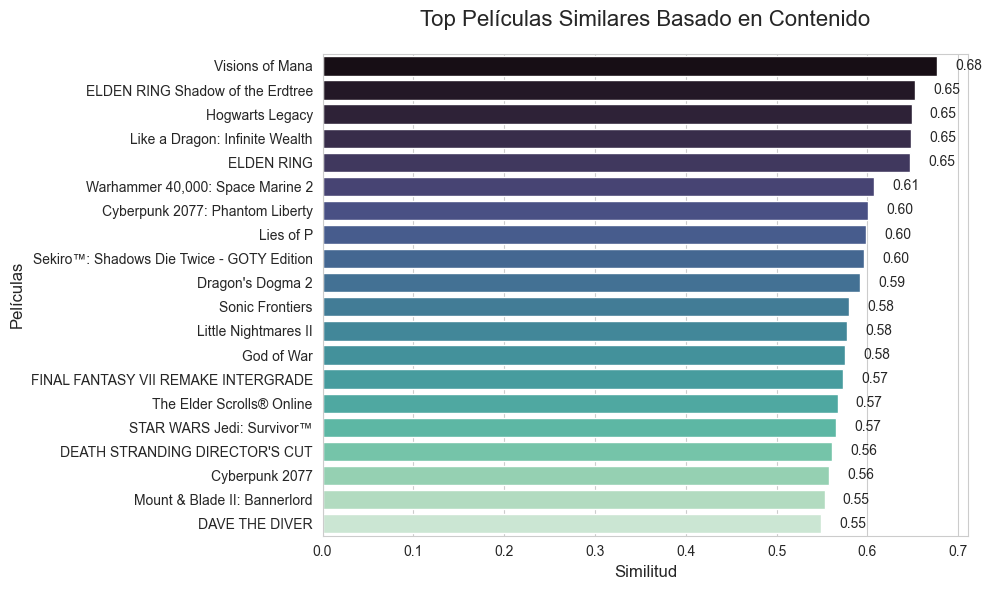

In [8]:
# y ahora buscamos el título
top_simiar_movies = {}
for i in peli_similares_ordenadas:
    top_simiar_movies[sr.get_title_from_index(i[0], df_contenido)] = i[1]

# visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_simiar_movies.values()), 
    y=list(top_simiar_movies.keys()), 
    palette="mako"
)

# Añadir etiquetas y título
plt.title("Top Películas Similares Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Películas", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_simiar_movies.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()
